In [149]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten, tree_structure
import jax_dataclasses as jdc
import chex
from functools import partial
from typing import Callable
import os
from exciting_environments import PMSM_Physical,PMSM
from exciting_environments.pmsm import FastPMSM

In [150]:
random_seed_DQN = np.random.randint(0, 2**31)
random_key_DQN = jax.random.PRNGKey(seed=random_seed_DQN)
random_seed_motor = np.random.randint(0, 2**31)
random_key_motor = jax.random.PRNGKey(seed=random_seed_motor)

random_seed = np.random.randint(0, 2**31)
random_key = jax.random.PRNGKey(seed=random_seed)

In [185]:
new_motor = PMSM_Physical(control_state="currents", deadtime=1,batch_size=1,saturated=True)

In [186]:
new_motor_env = PMSM(new_motor, gamma=0.85,batch_size=1)
#obs, motor_env_state = new_motor_env.reset(random_key_motor)

In [187]:
new_motor_env.env_properties.action_constraints

PMSM.Actions(u_dq=266.6666666666667)

In [188]:
EPISODE_LENGTH = 500
NUM_EPISODES = 2_000
NUM_STATES = 2
x_star = np.zeros((NUM_STATES, NUM_EPISODES, NUM_STATES))
new_motor_env2 = FastPMSM(x_star,batch_size=2,saturated=True)
#obs, motor_env_state = new_motor_env.reset(random_key_motor)

In [189]:
new_motor_env2.reset()

(array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]),
 {},
 False,
 {})

In [190]:
new_motor_env2.step(np.array([[1,1],[1,1]]))

(array([[0.16602741, 0.04005779, 0.03141593, 0.        , 0.        ,
         0.81341357, 0.90052741],
        [0.16602741, 0.04005779, 0.03141593, 0.        , 0.        ,
         0.81341357, 0.90052741]]),
 {},
 array([False, False]),
 {})

### Comparison

In [191]:
obs, motor_env_state = new_motor_env.reset(random_key_motor)

In [192]:
obs

Array([[ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.22396398, -0.4748397 ,  0.        ,  0.        ]],      dtype=float32)

### Step comparison

In [201]:
next_state=motor_env_state
i_dqs=[]
for _ in range(10000):
    next_state,obs_next,reward,done=new_motor_env.vmap_step(next_state,jnp.array([[-0,1]]))
    i_dqs.append(obs_next[0,0:2])

In [202]:
i_dqs

[Array([0., 0.], dtype=float32),
 Array([-0.00117267, -0.00117267], dtype=float32),
 Array([-0.00226625, -0.00226625], dtype=float32),
 Array([-0.00328366, -0.00328366], dtype=float32),
 Array([-0.00422809, -0.00422809], dtype=float32),
 Array([-0.00510292, -0.00510292], dtype=float32),
 Array([-0.00591166, -0.00591166], dtype=float32),
 Array([-0.00665792, -0.00665792], dtype=float32),
 Array([-0.0073453, -0.0073453], dtype=float32),
 Array([-0.00797742, -0.00797742], dtype=float32),
 Array([-0.00855784, -0.00855784], dtype=float32),
 Array([-0.00909003, -0.00909003], dtype=float32),
 Array([-0.00957736, -0.00957736], dtype=float32),
 Array([-0.01002308, -0.01002308], dtype=float32),
 Array([-0.01043027, -0.01043027], dtype=float32),
 Array([-0.01080188, -0.01080188], dtype=float32),
 Array([-0.01114071, -0.01114071], dtype=float32),
 Array([-0.01144938, -0.01144938], dtype=float32),
 Array([-0.01173034, -0.01173034], dtype=float32),
 Array([-0.0119859, -0.0119859], dtype=float32),
 A

In [203]:
import matplotlib.pyplot as plt

(-1.0, 1.0)

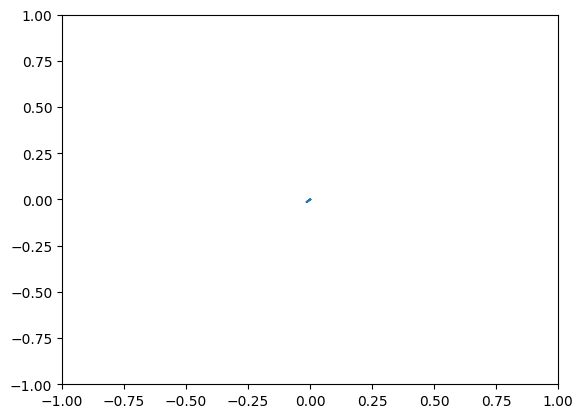

In [204]:
plt.plot(jnp.array(i_dqs)[:,0],jnp.array(i_dqs)[:,1])
plt.xlim(-1,1)
plt.ylim(-1,1)

In [205]:
next_state2,obs_next2,reward2,done2=new_motor_env2.step(motor_env_state2,jnp.array([[0,1]]))

NameError: name 'motor_env_state2' is not defined

In [38]:
obs_next2

Array([[ 0.0000000e+00,  0.0000000e+00,  3.4061984e-05,  1.0000000e+00,
         0.0000000e+00,  2.2062254e-01, -4.6504974e-01,  0.0000000e+00,
         1.0000000e+00]], dtype=float32)

In [16]:
next_state

PMSM.States(physical_state=PMSM_Physical.PhysicalState(action_buffer=Array([[[  0.     , 266.66666]]], dtype=float32), epsilon=Array([0.], dtype=float32), i_d=Array([0.], dtype=float32), i_q=Array([0.], dtype=float32), torque=Array([0.], dtype=float32), omega=Array([-0.00032567], dtype=float32)), PRNGKey=Array([[ 520295942, 1650227225]], dtype=uint32), optional=PMSM.Optional(omega_add=Array([[-3.109891e-05]], dtype=float32), omega_count=Array([[24666.]], dtype=float32), references=Array([[-0.9234686 ,  0.00126839]], dtype=float32)))

In [17]:
next_state2

{'physical_state': {'action_buffer': Array([[[  0.     , 266.66666]]], dtype=float32),
  'epsilon': Array([[0.]], dtype=float32),
  'i_d': Array([[0.]], dtype=float32),
  'i_q': Array([[0.]], dtype=float32),
  'omega': Array([[-0.00032567]], dtype=float32),
  'torque': Array([[0.]], dtype=float32)},
 'omega_add': Array([[-3.109891e-05]], dtype=float32),
 'omega_count': Array([[24666.]], dtype=float32),
 'keys': Array([[ 520295942, 1650227225]], dtype=uint32),
 'references': Array([[-0.9234686 ,  0.00126839]], dtype=float32)}